In [1]:
import gym_xy
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from scipy.linalg import expm, logm
import random
from mpl_toolkits import mplot3d
import scipy.integrate as integrate
from sympy import lambdify, Matrix

In [2]:
from gym.wrappers import Monitor

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import math
import copy

In [5]:
def Pauli(n):
    if n==0:
      return np.eye(2)
    elif n==1:
      return np.array([[0,1],[1,0]])
    elif n==2:
      return np.array([[0,-1j],[1j,0]])
    elif n==3:
      return np.array([[1,0],[0,-1]])
    else:
      raise ValueError('Input must be integer from 0 to 3.')

# returns sigma_a^p*sigma_b^q, with a,b = 1,2,3, p,q being position
def Kron2body(N_atom,a,b,p,q):
    y=1
    for i in range(N_atom):
        if i==p:
            y=np.kron(y,Pauli(a))
        elif i==q:
            y=np.kron(y,Pauli(b))
        else:
            y=np.kron(y,np.eye(2))
    return y

def Hamiltonian(N_atom,bc,cplist,model):
    H=np.zeros((2**N_atom,2**N_atom))
    for pp in range(len(cplist)):
        for p in range(N_atom):
            if bc=='p':
                q=(p+pp+1)%N_atom
            elif bc=='o':
                q=p+pp+1
                if q>=N_atom:
                    continue
            H=H+cplist[pp]*(model[0]*Kron2body(N_atom,1,1,p,q)
                            +model[1]*Kron2body(N_atom,2,2,p,q)
                            +model[2]*Kron2body(N_atom,3,3,p,q))+model[3]*Kron2body(N_atom,3,0,p,q)
    if np.max(np.abs(np.imag(H)))<1e-10:                                         #why?
        H=np.real(H)
    return H

In [6]:
class CartPoleAI(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc = nn.Sequential(
                        nn.Linear(13,128, bias=True),
                        nn.ReLU(),
#                         nn.Linear(64,64, bias=True),
#                         nn.ReLU(),
#                         nn.Linear(128,128, bias=True),
#                         nn.ReLU(),
#                         nn.Linear(64,64, bias=True),
#                         nn.ReLU(),
                        nn.Linear(128,5, bias=True),
                        nn.Softmax(dim=1)
                        )##### first one state_dim=(e.g.13) last one action_dim=(e.g.5)

                
        def forward(self, inputs):
            x = self.fc(inputs)
            return x

In [7]:
def init_weights(m):
    
        # nn.Conv2d weights are of shape [16, 1, 3, 3] i.e. # number of filters, 1, stride, stride
        # nn.Conv2d bias is of shape [16] i.e. # number of filters
        
        # nn.Linear weights are of shape [32, 24336] i.e. # number of input features, number of output features
        # nn.Linear bias is of shape [32] i.e. # number of output features
        
        if ((type(m) == nn.Linear) | (type(m) == nn.Conv2d)):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.00)
                

In [8]:
def return_random_agents(num_agents):
    
    agents = []
    for _ in range(num_agents):
        
        agent = CartPoleAI()
        
        for param in agent.parameters():
            param.requires_grad = False
            
        init_weights(agent)
        agents.append(agent)
        
        
    return agents
    

In [9]:
def run_agents(agents):
    
    reward_agents = []
    env = gym.make('xy-v0')
    
    
    maxTime=12
    nSpin=3
    min_delay=0
    max_delay=1
    pw=0.5
    env.setParam(maxTime,nSpin,min_delay,max_delay,pw)



    Aim=np.zeros([2**nSpin,2**nSpin])
    env.setTargetH(Aim)
    env.setTarget(expm(-1j*Aim))
    

    H=Hamiltonian(nSpin,'p',[1],[-0.5,-0.5,1,0])
    J=8.18e-3
    env.setH0(J*H)   
    env.set_pulse()
    
    for agent in agents:
        agent.eval()
    
        observation,info = env.reset()
        
        r=0
        s=0
        
        for i in range(maxTime):
            
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
#             print(inp)
            output_probabilities = agent(inp).detach().numpy()[0]
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            new_observation, reward, done, info = env.step(action,i)
            r=r+reward
            
            s=s+1
            observation = new_observation

            if(done):
                break

        reward_agents.append(r)        
        #reward_agents.append(s)
#         if r>27:
#             print(r)
#             print(observation)
        
    
    return reward_agents

In [10]:
def return_average_score(agent, runs):
    score = 0.
    for i in range(runs):
        score += run_agents([agent])[0]
    return score/runs

#     score=0.
#     for i in range(runs):
#         temp=run_agents([agent])[0]
#         if temp>score:
#              score = temp
#     return score

In [11]:
def run_agents_n_times(agents, runs):
    avg_score = []
    for agent in agents:
        avg_score.append(return_average_score(agent,runs))
    return avg_score

In [12]:
def mutate(agent,power):

    child_agent = copy.deepcopy(agent)
    
    mutation_power = power#hyper-parameter, set from https://arxiv.org/pdf/1712.06567.pdf
            
    for param in child_agent.parameters():
    
        if(len(param.shape)==4): #weights of Conv2D

            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    for i2 in range(param.shape[2]):
                        for i3 in range(param.shape[3]):
                            
                            param[i0][i1][i2][i3]+= mutation_power * np.random.randn()
                                
                                    

        elif(len(param.shape)==2): #weights of linear layer
            for i0 in range(param.shape[0]):
                for i1 in range(param.shape[1]):
                    
                    param[i0][i1]+= mutation_power * np.random.randn()
                        

        elif(len(param.shape)==1): #biases of linear layer or conv layer
            for i0 in range(param.shape[0]):
                
                param[i0]+=mutation_power * np.random.randn()

    return child_agent

In [13]:
def crossover(agent1,agent2):
    child_agent = copy.deepcopy(agent1)
    child_agent2 = copy.deepcopy(agent2)
    cross_weight=[]
    cross_bias=[]
    p1=0
    p2=0
    for param2 in child_agent2.parameters():
        if (len(param2.shape)==2):
            cross_weight.append(param2[0:int(param2.shape[0]/2)][0:int(param2.shape[1]/2)])
        elif (len(param2.shape)==1):
            cross_bias.append(param2[0:int(param2.shape[0]/2)])
    for param in child_agent.parameters():
        if (len(param.shape)==2):
            param[0:int(param.shape[0]/2)][0:int(param.shape[1]/2)]=cross_weight[p1]
            p1+=1
        elif (len(param.shape)==1):
            param[0:int(param.shape[0]/2)]=cross_bias[p2]
            p2+=1
        
        
#     for param in child_agent.parameters():
#         for param2 in child_agent2.parameters():
#             if (len(param.shape)==2 and len(param2.shape)==2): #weights of linear layer
#                 crossover_point0=int(param.shape[0]/2)
#                 crossover_point1=int(param.shape[1]/2)
#                 end0=param.shape[0]
#                 end1=param.shape[1]
#                 print(int(param.shape[0]/2))
#                 print(int(param2.shape[0]/2))
#                 print(param.shape[0])
#                 for i in range(crossover_point1):
#                     for j in range(crossover_point0):
#                         param[j][i]=param2[j][i]

#             elif (len(param.shape)==1 and len(param2.shape)==1): #weights of linear layer
#                 crossover_point0=int(param.shape[0]/2)
#                 end0=param.shape[0]
#                 param[0:crossover_point0]=param2[0:crossover_point0]
    return child_agent

In [14]:
def return_children(agents, sorted_parent_indexes, elite_index,gen):
    
    children_agents = []
    children_crossover = []
#     children_crossover = crossover(agents[selected_agent_index])
    #Crossover: take selected parents from sorted_parent_indexes and generate N-1 children
    for i in range(len(agents)-1):
        selected_agent_index_crossover1 = sorted_parent_indexes[np.random.randint(len(sorted_parent_indexes))]
        selected_agent_index_crossover2 = sorted_parent_indexes[np.random.randint(len(sorted_parent_indexes))]
        
        children_crossover.append(crossover(agents[selected_agent_index_crossover1],agents[selected_agent_index_crossover2]))

    #Mutation:first take selected parents from sorted_parent_indexes and generate N-1 children
    if gen%2==0:
        for i in range(len(agents)-1):

#             selected_agent_index = sorted_parent_indexes[np.random.randint(len(sorted_parent_indexes))]
             
            if gen%10==0:
                children_agents.append(mutate(children_crossover[i],0.05))
            else:
                children_agents.append(mutate(children_crossover[i],0.005))
    else:
        children_agents = children_crossover


    #now add one elite
    elite_child, top_score = add_elite(agents, sorted_parent_indexes, elite_index)
    children_agents.append(elite_child)
    elite_index=len(children_agents)-1 #it is the last one
    
    return children_agents, elite_index, top_score

In [15]:
def add_elite(agents, sorted_parent_indexes, elite_index=None, only_consider_top_n=20):
    
    candidate_elite_index = sorted_parent_indexes[:only_consider_top_n]
    
    if(elite_index is not None):
        candidate_elite_index = np.append(candidate_elite_index,[elite_index])
        
    top_score = None
    top_elite_index = None
    
    for i in candidate_elite_index:
        score = return_average_score(agents[i],runs=3)
        print("Score for elite i ", i, " is ", score)
        
        if(top_score is None):
            top_score = score
            top_elite_index = i
        elif(score > top_score):
            top_score = score
            top_elite_index = i
            
    print("Elite selected with index ",top_elite_index, " and score", top_score)
    
    child_agent = copy.deepcopy(agents[top_elite_index])
    return child_agent, top_score
    

In [16]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [17]:
# def selection(n,rewards,topn):
#     t0=1
#     tf=1e-4
#     yita=0.1
#     lamb=1
#     nc=21
#     t=t0*(tf/t0)**(n/nc)*(1-yita*np.sin(lamb*np.pi*n/nc))
#     qbest=np.amax(rewards)
#     q=np.exp((rewards-qbest)/t)
#     prob=q/np.sum(q)
# #     print(list(enumerate(rewards)))
          
#     return np.random.choice(len(rewards),topn,p=prob)
    

In [18]:
game_actions = 5 

#disable gradients as we will not use them
torch.set_grad_enabled(False)

# initialize N number of agents
num_agents = 20000
agents = return_random_agents(num_agents)

# How many top agents to consider as parents
top_limit = 40

# run evolution until X generations
generations = 100

elite_index = None

mean_reward=[]
mean_top5_reward=[]
top_reward=[]
elite_reward=[]

for generation in range(generations):
#     print(generation)

    # return rewards of agents
    rewards = run_agents_n_times(agents, 2) #return average of 3 runs
#     print(rewards)
#     print("")

    # sort by rewards
#     print(np.argsort(rewards)[::-1][:top_limit])
    sorted_parent_indexes = np.argsort(rewards)[::-1][:top_limit]
#     sorted_parent_indexes = selection (generation,rewards,top_limit)
#     print(sorted_parent_indexes)
    #reverses and gives top values (argsort sorts by ascending by default) https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
    print("")
    print("")
    
    top_rewards = []
    for best_parent in sorted_parent_indexes:
        top_rewards.append(rewards[best_parent])
    
    print("Generation ", generation, " | Mean rewards: ", np.mean(rewards), " | Mean of top 5: ",np.mean(top_rewards[:5]))
    #print(rewards)
    print("Top ",top_limit," scores", sorted_parent_indexes)
    print("Rewards for top: ",top_rewards)
    mean_reward.append(np.mean(rewards))
    mean_top5_reward.append(np.mean(top_rewards[:5]))
    top_reward.append(top_rewards[0])
#     if top_rewards[0]>27:
#         break
    
    # setup an empty list for containing children agents
    children_agents, elite_index, top_score = return_children(agents, sorted_parent_indexes, elite_index,generation)
    elite_reward.append(top_score)
    # kill all agents, and replace them with their children
    agents = children_agents



Generation  0  | Mean rewards:  4.851483385466023  | Mean of top 5:  12.945007040625196
Top  40  scores [ 8603  8131 10633 10780 10377  3024 13578 15480 18241  9748 13443 11053
 16430  6238 13599 12939  3644 14392  3684  4147  4402 10546 17014  6276
  1114  7552  1257 10982  4129  2502 10473 19327 16791  3617  7620   788
 12182  3128  2286  9417]
Rewards for top:  [13.768882321657795, 13.756043050030101, 12.531624792743582, 12.491878551709643, 12.176606486984864, 12.122181615182162, 12.090289828732383, 12.05931953146745, 12.042581832151482, 12.00030610943065, 11.958308308708668, 11.91984866161957, 11.894402894077091, 11.80577869420791, 11.761960586957695, 11.601182017296885, 11.519734602614673, 11.509462143176728, 11.49694216275876, 11.479605176165375, 11.340094644308891, 11.274477434014916, 11.181400157256103, 11.104402033181799, 10.98648398561367, 10.890897126580485, 10.816545996482978, 10.708510096438623, 10.004177169267214, 10.003038683517179, 9.999071685701562, 9.989227566758473

Score for elite i  10389  is  4.5308728678335655
Score for elite i  1310  is  4.6391552118173545
Score for elite i  369  is  4.720629664585606
Score for elite i  8792  is  4.637797286944655
Score for elite i  9802  is  4.744801399883694
Score for elite i  17640  is  4.7361266504159865
Score for elite i  1126  is  4.520644865070411
Score for elite i  19999  is  4.5471091381081665
Elite selected with index  13777  and score 7.562719134941136


Generation  4  | Mean rewards:  4.851400795583613  | Mean of top 5:  13.027383112044436
Top  40  scores [ 3440  3587  1982 12627  4562 16095  9049  4051 10409  9307 17440 17389
  9688 11651  1657 14093 19305 18848 10538 13380 12386  2440  5828  2714
 16665 17144 12274 11062 14189 11920 14934  3891  3330 12805  7536 16160
 10979  2039 16931 11293]
Rewards for top:  [13.764802844757721, 13.764050857392188, 12.57589268487579, 12.542231942832348, 12.489937230364136, 12.444784419571855, 12.059792297881994, 12.058896342941186, 12.058743637994809, 12.0560

Score for elite i  19988  is  4.660324024275609
Score for elite i  9006  is  6.915048026180408
Score for elite i  13673  is  4.719253913729422
Score for elite i  5686  is  4.561783778056861
Score for elite i  6747  is  4.480248238630449
Score for elite i  12907  is  4.926278952124915
Score for elite i  6491  is  4.589582311689822
Score for elite i  17134  is  4.535048313060723
Score for elite i  822  is  4.681347087385414
Score for elite i  2384  is  4.664917116754965
Score for elite i  17498  is  4.76276906910324
Score for elite i  11558  is  7.236892063678515
Score for elite i  16486  is  4.733072230365827
Score for elite i  10470  is  4.638453703138208
Score for elite i  4863  is  4.547151516848838
Score for elite i  15224  is  4.359266692002467
Score for elite i  9791  is  7.3106810737810335
Score for elite i  16578  is  4.5756982290764725
Score for elite i  14261  is  4.5939143008706536
Score for elite i  13527  is  4.761330566225396
Score for elite i  19999  is  4.560146539532819

Score for elite i  19374  is  4.6471700524714645
Score for elite i  4460  is  4.574833503446224
Score for elite i  17396  is  4.833960847615782
Score for elite i  18474  is  4.547293424659837
Score for elite i  15062  is  4.535559644407616
Score for elite i  17658  is  6.760494741646731
Score for elite i  596  is  7.336492496728238
Score for elite i  14100  is  4.5854421713571165
Score for elite i  15151  is  4.7688489033406
Score for elite i  3518  is  4.831683889913872
Score for elite i  12034  is  4.705560991092134
Score for elite i  6359  is  7.43674409152707
Score for elite i  12019  is  4.7451846628673335
Score for elite i  11923  is  4.7610003675854475
Score for elite i  18034  is  4.493699425573897
Score for elite i  19010  is  4.770438195587272
Score for elite i  6486  is  4.545950372891892
Score for elite i  19255  is  4.671692881327893
Score for elite i  9168  is  6.887502786176168
Score for elite i  13921  is  4.785829470611132
Score for elite i  19999  is  4.76942376709354

Score for elite i  3434  is  4.92552788632386
Score for elite i  8365  is  4.835970230579165
Score for elite i  5100  is  4.760299947586767
Score for elite i  1675  is  4.712681727758082
Score for elite i  4069  is  4.352778075814821
Score for elite i  19007  is  4.547832980836422
Score for elite i  10749  is  4.358647018901878
Score for elite i  6289  is  4.507989099848959
Score for elite i  41  is  4.45922341567224
Score for elite i  15681  is  6.717653553690461
Score for elite i  13440  is  4.530418219350804
Score for elite i  6142  is  4.640669974901276
Score for elite i  3483  is  4.806356700321968
Score for elite i  11662  is  4.355804117484812
Score for elite i  19165  is  4.550209868140913
Score for elite i  9476  is  4.7608612144648275
Score for elite i  13527  is  4.6524711493725155
Score for elite i  16331  is  4.576251598719989
Score for elite i  19607  is  4.82973170149177
Score for elite i  12798  is  4.558733289350852
Score for elite i  19999  is  4.829581357939046
Elite

Score for elite i  13190  is  4.736296490945306
Score for elite i  7565  is  4.667570343474644
Score for elite i  6102  is  4.350358902529032
Score for elite i  15542  is  4.856392611760083
Score for elite i  8001  is  4.736498037869627
Score for elite i  19332  is  4.737753342379178
Score for elite i  8355  is  4.435127816607455
Score for elite i  10414  is  4.580833212819149
Score for elite i  17205  is  4.41865379101148
Score for elite i  8480  is  4.598481607008331
Score for elite i  14349  is  6.851530305268881
Score for elite i  7489  is  4.64624819679312
Score for elite i  17514  is  4.541741192490618
Score for elite i  5645  is  4.549125852888641
Score for elite i  11852  is  8.253287034083561
Score for elite i  629  is  4.454255354465938
Score for elite i  9369  is  4.569454339126749
Score for elite i  16696  is  6.45252522443552
Score for elite i  2445  is  4.763499815265807
Score for elite i  4748  is  4.3907981739832165
Score for elite i  19999  is  4.841232587509347
Elite 

Score for elite i  30  is  4.83273481181978
Score for elite i  17899  is  4.6423667429991085
Score for elite i  8257  is  4.637509385340233
Score for elite i  1414  is  7.239305615074588
Score for elite i  9288  is  4.730131112089162
Score for elite i  16540  is  4.583114814785001
Score for elite i  4392  is  4.73885018855929
Score for elite i  8958  is  4.677601988503777
Score for elite i  5304  is  4.562216448207575
Score for elite i  14506  is  4.571839639772885
Score for elite i  9898  is  4.612834384103678
Score for elite i  19629  is  4.575430089862266
Score for elite i  2002  is  4.7378202710789035
Score for elite i  1661  is  4.570863143654628
Score for elite i  17634  is  4.641473103232817
Score for elite i  14129  is  4.708823052968266
Score for elite i  4515  is  4.7101120393741
Score for elite i  14197  is  4.714323233018255
Score for elite i  13754  is  4.55139430648126
Score for elite i  11069  is  4.637654495454058
Score for elite i  19999  is  4.586810067237451
Elite se

Score for elite i  13641  is  4.367402997151969
Score for elite i  12226  is  6.843170278007171
Score for elite i  6066  is  4.643881208212462
Score for elite i  10410  is  4.710103646773354
Score for elite i  12309  is  6.57233549401001
Score for elite i  11160  is  4.736964348662274
Score for elite i  11449  is  4.777779009340794
Score for elite i  607  is  4.4788902360349425
Score for elite i  15844  is  4.549490824712684
Score for elite i  2407  is  4.76265997525191
Score for elite i  1741  is  4.301481119075731
Score for elite i  15234  is  4.66751304906168
Score for elite i  1254  is  4.601528937462017
Score for elite i  8794  is  4.5537890917333
Score for elite i  9182  is  4.857621544327295
Score for elite i  19072  is  4.647407501241873
Score for elite i  5750  is  4.646154865456395
Score for elite i  16193  is  4.6737606905748805
Score for elite i  19448  is  4.720024523604151
Score for elite i  13952  is  4.413638749482842
Score for elite i  19999  is  4.584511124192869
Elit

Score for elite i  16947  is  4.759481596464573
Score for elite i  18647  is  4.667658591459752
Score for elite i  15303  is  4.601705750566146
Score for elite i  749  is  7.310298402792212
Score for elite i  9596  is  4.612455382508924
Score for elite i  5166  is  6.845678811235615
Score for elite i  17226  is  4.742810276277489
Score for elite i  14431  is  7.1788364444690975
Score for elite i  3677  is  4.455857422656316
Score for elite i  14261  is  4.592232798228573
Score for elite i  3894  is  4.386247541403441
Score for elite i  351  is  4.856257396563781
Score for elite i  7270  is  4.785224428887956
Score for elite i  13969  is  7.055645761913767
Score for elite i  8326  is  4.5809453998975735
Score for elite i  16554  is  7.045425797637077
Score for elite i  19788  is  4.6488709524957565
Score for elite i  7057  is  4.834346291384603
Score for elite i  15298  is  4.553249965110699
Score for elite i  1261  is  4.857300363489639
Score for elite i  19999  is  4.708950253540546
E

Score for elite i  3986  is  4.7627024562681415
Score for elite i  15981  is  4.326930981945797
Score for elite i  2744  is  4.121500921988095
Score for elite i  14446  is  4.857400864239899
Score for elite i  810  is  10.199959446404927
Score for elite i  11221  is  4.850493257692514
Score for elite i  3496  is  4.64091058500423
Score for elite i  17280  is  4.35790559935257
Score for elite i  4298  is  4.833323622332199
Score for elite i  16324  is  6.695901117591962
Score for elite i  6306  is  4.395032064911548
Score for elite i  7589  is  4.689555585472442
Score for elite i  17361  is  4.439394085552004
Score for elite i  9481  is  4.711813564278352
Score for elite i  4439  is  4.760697683584613
Score for elite i  232  is  7.5259249003293105
Score for elite i  6978  is  4.742274216134609
Score for elite i  16978  is  4.67985040325117
Score for elite i  19560  is  4.50202745853972
Score for elite i  15495  is  4.732673534935395
Score for elite i  19999  is  4.349927525322303
Elite 

Score for elite i  13453  is  4.7380250562573325
Score for elite i  16453  is  4.666437793973273
Score for elite i  12875  is  4.456554894004822
Score for elite i  19406  is  4.733094444206195
Score for elite i  7847  is  4.512198127316592
Score for elite i  11153  is  4.73975024912536
Score for elite i  1213  is  4.569506456587425
Score for elite i  3313  is  6.674448780846273
Score for elite i  13618  is  4.681328754514816
Score for elite i  10515  is  4.708641680694704
Score for elite i  17251  is  7.597271284913958
Score for elite i  18240  is  4.5082640242895655
Score for elite i  1659  is  4.801391299699872
Score for elite i  4212  is  4.539152187607268
Score for elite i  8604  is  4.7495383300938165
Score for elite i  3753  is  4.644002239311868
Score for elite i  11496  is  4.729029409230315
Score for elite i  10419  is  4.480788174715861
Score for elite i  14038  is  4.832517284926084
Score for elite i  11040  is  4.761673864826781
Score for elite i  19999  is  4.7989920163948

Score for elite i  11019  is  4.354603068235431
Score for elite i  130  is  4.647446724896903
Score for elite i  5686  is  4.857193774828914
Score for elite i  7130  is  4.637557047900482
Score for elite i  18586  is  4.558979387502583
Score for elite i  18676  is  4.7052609282622555
Score for elite i  8055  is  4.67491806461227
Score for elite i  3832  is  4.6671502889522865
Score for elite i  18793  is  4.436324999224122
Score for elite i  14322  is  4.665819060618278
Score for elite i  18370  is  4.57479061955644
Score for elite i  12207  is  4.602968240338498
Score for elite i  1684  is  4.778025256610424
Score for elite i  14339  is  4.674334594461389
Score for elite i  2360  is  4.64697790198191
Score for elite i  5458  is  4.585831253998765
Score for elite i  13223  is  4.778205253800357
Score for elite i  351  is  4.185219215943754
Score for elite i  4266  is  4.714095624558438
Score for elite i  15167  is  8.159722706282894
Score for elite i  19999  is  7.1844675710681685
Elit

KeyboardInterrupt: 

In [19]:
np.savetxt('GA-cross_128.csv',np.array([mean_reward,mean_top5_reward,top_reward,elite_reward]).T,fmt=['%.7f','%.7f','%.7f','%.7f'],delimiter=',',header="mean_reward,mean_top5_reward,top_reward,elite_reward")






AttributeError: fmt has wrong shape.  ['%.7f', '%.7f', '%.7f', '%.7f']

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


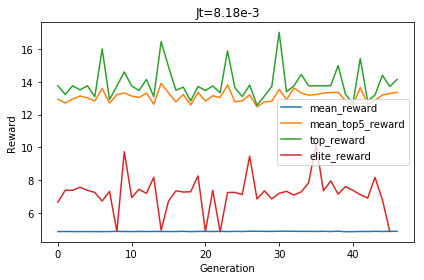

In [20]:
# fig, ax = plt.subplots(figsize=(5,4),tight_layout=True)
fig, ax = plt.subplots(tight_layout=True)

ax.plot(mean_reward)
ax.plot(mean_top5_reward)
ax.plot(top_reward)
ax.plot(elite_reward)


# ax.set_xscale('log')

ax.set(xlabel='Generation', ylabel='Reward',
       title='Jt=8.18e-3')        ### The 12 pulse sequence is compared with the 6 pulse sequence
                                   ### We regard the 6 pulse sequence is T long, the 12 pulse sequence is 2T long 

plt.legend(['mean_reward', 'mean_top5_reward','top_reward', 'elite_reward'], loc='best')

plt.savefig('GA-cross_128.eps', dpi=fig.dpi, bbox_inches='tight')

In [ ]:
def play_agent(agent):
#     try: #try and exception block because, render hangs if an erorr occurs, we must do env.close to continue working    
        env = gym.make('xy-v0')


        maxTime=12
        nSpin=3
        min_delay=0
        max_delay=1
        pw=0.5
        env.setParam(maxTime,nSpin,min_delay,max_delay,pw)



        Aim=np.zeros([2**nSpin,2**nSpin])
        env.setTargetH(Aim)
        env.setTarget(expm(-1j*Aim))

        H=Hamiltonian(nSpin,'p',[1],[-0.5,-0.5,1,0])
        J=8.18e-3
        env.setH0(J*H) 
        env.set_pulse()
        
        observation,info = env.reset()
        last_observation = observation
        r=0
        for i in range(12):
#             env_record.render()
            inp = torch.tensor(observation).type('torch.FloatTensor').view(1,-1)
            output_probabilities = agent(inp).detach().numpy()[0]
            action = np.random.choice(range(game_actions), 1, p=output_probabilities).item()
            print(action)
            new_observation, reward, done, info = env.step(action,i)
            r=r+reward
            observation = new_observation

            if(done):
                break

#         env_record.close()
        print("Rewards: ",r)
        print(observation)

#     except Exception as e:
# #         env_record.close()
#         print(e.__doc__)
#         print(e.message)        

In [ ]:
play_agent(agents[406])

## Test sequence

In [ ]:
def test_agent():
#     try: #try and exception block because, render hangs if an erorr occurs, we must do env.close to continue working    
        env = gym.make('xy-v0')


        maxTime=12
        nSpin=3
        min_delay=0
        max_delay=1
        pw=0.5
        env.setParam(maxTime,nSpin,min_delay,max_delay,pw)


        Aim=np.zeros([2**nSpin,2**nSpin])
        env.setTargetH(Aim)
        env.setTarget(expm(-1j*Aim))

        H=Hamiltonian(nSpin,'p',[1],[-0.5,-0.5,1,0])
        J=8.18e-3
        env.setH0(J*H)  
        env.set_pulse()
        
        observation,info = env.reset()
        last_observation = observation
        r=0
    
        
        new_observation, reward, done, info = env.step(0,0)
        new_observation, reward, done, info = env.step(0,1)
        new_observation, reward, done, info = env.step(0,2)
        new_observation, reward, done, info = env.step(0,3)
        new_observation, reward, done, info = env.step(0,4)
        new_observation, reward, done, info = env.step(0,5)
        new_observation, reward, done, info = env.step(0,6)
        new_observation, reward, done, info = env.step(0,7)
        new_observation, reward, done, info = env.step(0,8)
        new_observation, reward, done, info = env.step(0,9)
        new_observation, reward, done, info = env.step(0,10)
        new_observation, reward, done, info = env.step(0,11)
        r=r+reward
#         H1=env.getAHT1()
#         H2=env.getAHT2()
#         H3=env.getAHT3()
# #         H4=env.getAHT4()
# #         print(np.trace(np.transpose(np.conjugate(H1))*H1))
# #         print(np.trace(np.transpose(np.conjugate(H2))*H2))
# #         print(np.trace(np.transpose(np.conjugate(H3))*H3))
# #         print(np.trace(np.transpose(np.conjugate(H4))*H4))
#         print(-np.log(1-np.trace(expm(-1j*H1))/8))
#         print(-np.log(1-np.trace(expm(-1j*(H1+H2)))/8))
#         print(-np.log(1-np.trace(expm(-1j*(H1+H2+H3)))/8))
#         print('fidelity')
#         print(np.abs(np.sum(H1*np.transpose(np.conjugate(self.target)))/2**self.nSpin))

#         if(done):
#             break

        print("Rewards: ",r)
        print(new_observation)

#     except Exception as e:
# #         env_record.close()
#         print(e.__doc__)
#         print(e.message)        

In [ ]:
test_agent()

In [ ]:
print(np.random.randint(5,size=2))